In [10]:
import glob
import os
from nltk.corpus import stopwords
import string
import math
import numpy as np
from nltk.tokenize import RegexpTokenizer
from matplotlib import pyplot as plt
from scipy.spatial import distance
from nltk.stem import PorterStemmer
import tkinter as tk
import random

porter_stemmer=PorterStemmer()
stop_words = set(stopwords.words('english'))

## function to get files from directory

In [11]:
def getdatafromfile():
    classes=['athletics','cricket','football','rugby','tennis']
    list=[glob.glob('bbcsport/{}/*'.format(classes[i])) for i in range(len(classes))]
    return list,classes

## KNN Classification Class

In [19]:
class TextClassificationKNN:
    def __init__(self,list,classes):
        self.list=list
        self.classes=classes
        self.totalfiles=[len(i) for i in list]
        print("Total files in each class: ",self.totalfiles)
        
        
    def preprocessData(self):

        self.alldocDict={}
        for mainClass in range(len(self.list)): 
            for subFiles in range(len(self.list[mainClass])):
                f=open(self.list[mainClass][subFiles],'r')
                tokenizer = RegexpTokenizer(r'\w+')
                # convert to lower case
                fullfile = tokenizer.tokenize(f.read().lower())
                # stem document
                stemmedDocs=[porter_stemmer.stem(word) for word in fullfile]
                #trimming the file name and removing redundant '.txt'
                p=os.path.basename(self.list[mainClass][subFiles])
                p=p.split('.')[0]
                # remove all tokens that are not alphabetic and stop words
                tokens_without_sw = [word for word in stemmedDocs if word not in stop_words and word.isalpha()]
                self.alldocDict[mainClass,int(p)]=tokens_without_sw

        return self.alldocDict
    
    
    def SplitTrainTestDocs(self,testRatio):      
        
        self.train_count=[len(i)-(int(len(i)*(testRatio))) for i in self.list]        
        self.Train_documents=[]
        self.Test_documents=[]
        self.Train_set=[]        
        Train_Init=[]
        for classId in range(len(self.classes)):
            Train_Init.append(random.sample(range(1, self.totalfiles[classId]), self.train_count[classId]))

        for classId in range(len(self.classes)):
            for i in Train_Init[classId]:
                self.Train_documents.append((classId,i))
                self.Train_set.append(self.alldocDict[(classId,i)])

        for class_id in self.alldocDict.keys():
            if(class_id not in self.Train_documents):
                self.Test_documents.append(class_id)

        print("Number of test documents: ",len(self.Test_documents))
        print("Number of train documents: ",len(self.Train_documents))
        
        # index of words in training set(train_set has all the words that are in training set)
        self.word_index={}
        for doc in range(len(self.Train_set)):
            for word in self.Train_set[doc]:
                if word not in self.word_index:
                    self.word_index[word]={}
                    
        print(len(self.word_index))

        return self.Train_documents, self.Test_documents, self.word_index
    
    
    def tfidfCalculation(self,term_index):
        
        f = open("TFIDFdict_allDocs.txt","w")
        idf={}
        for word in term_index.keys():
            df=0
            for doc in self.alldocDict.keys():
                if word in self.alldocDict[doc]:
                    df+=1
            idf[word]=math.log(len(self.Train_documents)/(df))

        for word in term_index.keys():
            for doc in self.alldocDict.keys():      
                if word in self.alldocDict[doc]:
        #             print('word found in ',doc)   
                    term_index[word][doc]=((self.alldocDict[doc].count(word))*idf[word])  #calculate tfidf
                else:
                    term_index[word][doc]=0
        f.write(str(term_index))
        f.close()
        
        return term_index
    
    def formVectors(self,tfidf_dict):

        #form train and test vectors
        self.trainDoc_vect={}
        self.testDoc_vect={}

        f1 = open("TrainDocs_vector.txt","w")
        f2 = open("TestDocs_allDocs.txt","w")

        for docid in self.Train_documents:
            self.trainDoc_vect[docid]=[]
            for word in tfidf_dict.keys():
                self.trainDoc_vect[docid].append(tfidf_dict[word][docid])

        for docid in self.Test_documents:
            self.testDoc_vect[docid]=[]
            for word in tfidf_dict.keys():
                self.testDoc_vect[docid].append(tfidf_dict[word][docid])

        f1.write(str(self.trainDoc_vect))
        f1.close()
        f2.write(str(self.testDoc_vect))
        f2.close()

        return self.trainDoc_vect, self.testDoc_vect
    
    
    def calculateSimilarityAndKNN(self):
        self.testsimilarity={}
        for testid in self.testDoc_vect:
            self.testsimilarity[testid]={}
            for trainid in self.trainDoc_vect:
                self.testsimilarity[testid][trainid]=(distance.cosine(self.testDoc_vect[testid], self.trainDoc_vect[trainid]))
        self.correct=0
        self.no=0
        self.y=[]
        self.yp=[]
        for i in self.testsimilarity:
            n1,n2,n3=sorted(self.testsimilarity[i], key=self.testsimilarity[i].get)[0:3]
            newList=[n1[0],n2[0],n3[0]]
            frequentNN=max(set(newList), key = newList.count)
            
            self.y.append(i[0])
            self.yp.append(frequentNN)
        
            if(i[0]==frequentNN):
                self.correct+=1
            else:
                self.no+=1
                
    def visualize(self):
        plt.plot(range(len(self.y)), self.y, label='Actual Label')
        plt.plot(range(len(self.y)), self.yp, label='Predicted Label')
        plt.legend()
        plt.show()
        plt.savefig('ClassificationResultComparison.png')
    
    
    def getAccuracy(self):
        return (self.correct/(self.no+self.correct))*100
        


## get data from files

In [13]:
list,classes=getdatafromfile()

## Initialize class and split data into train and test, in ratio taken through gui, after preprocessing 

In [14]:
# gui for taking train and test ratio input

tr=0
def get_tr():
    root=tk.Tk()
    root.geometry("400x180")
    root.title('TrainTestRatio')
    def clicked():
        myLabel2 = tk.Label(root, text="The Test ratio is   "+e.get())
        global tr
        tr=float(e.get())
        trn=str(1-tr)
        myLabel2.grid()
        myLabel3 = tk.Label(root, text="The Train ratio is  "+trn).grid()
        myLabel4 = tk.Label(root, text="Please wait!").grid()
        root.after(1000, lambda: root.destroy()) # Destroy the widget after 3 seconds
              
    tk.Label(root, text="Enter The Test Ratio : ",fg="white", bg="powder blue", font=("Roboto",12), relief="groove").grid(row=0,padx=5)

    e = tk.Entry(root, font=("Ubuntu",11))
    e.grid(row=0,column=1,padx=5)
    e.insert(0,'0.3')
    
    tk.Label(root, text="Enter The Train Ratio : ",fg="white", bg="powder blue", font=("Roboto",12), relief="groove").grid(row=1,padx=5,pady=5)

    e1 = tk.Entry(root, font=("Ubuntu",11))
    e1.grid(row=1,column=1,padx=5,pady=5)
    e1.insert(0,'0.7')
    
    myBtn=tk.Button(root, text="Save and submit", command=clicked)
    myBtn.grid(row=2,column=1,pady=5)

    tk.mainloop()


get_tr() #getting the test ratio
print(tr)
clf=TextClassificationKNN(list,classes)
alldocDict=clf.preprocessData()
Train_documents, Test_documents, word_index=clf.SplitTrainTestDocs(tr)



0.3
Total files in each class:  [101, 124, 265, 147, 100]
Number of test documents:  220
Number of train documents:  517
8014


## form document vectors

In [15]:
tfidf_dict=clf.tfidfCalculation(word_index)
trainVector,testVector=clf.formVectors(tfidf_dict)

## calculate similarity and find K-Nearest Neighbour

In [16]:
clf.calculateSimilarityAndKNN()

## get accuracy

In [17]:
#due to random sampling, accuracy will vary between 96-99%

print(clf.getAccuracy())

99.0909090909091


## visualization

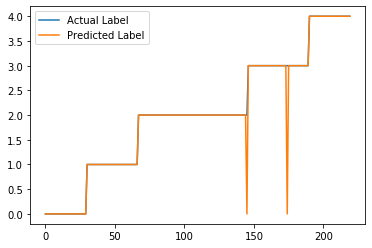

<Figure size 432x288 with 0 Axes>

In [20]:
clf.visualize()